In [ ]:
import re
import os
import glob
from shlex import quote
import subprocess
import csv
from six import string_types, text_type
import datetime
import shutil
from tqdm import tqdm
import multiprocessing as mp
from operator import itemgetter
import pickle
import numpy as np
from scipy.stats import linregress
from functools import partial
from tabulate import tabulate
import matplotlib.pyplot as plt
from ixapipes.tok import IxaPipesTokenizer #pip install ixapipes==0.0.6
from ixapipes.pos import IxaPipesPosTagger #pip install ixapipes==0.0.6
import emoji

Paths to the data that we need to run this repository

In [2]:
ikergazte_tweets = "/home/iker/Documents/ikergazte/ikergazte_data/"
ikergazte_tweets_formated = "/home/iker/Documents/ikergazte/ikergazte_data_formated/"
ikergazte_tweets_ixa_pipes="/home/iker/Documents/ikergazte/ikergazte_data_pos/"
ixa_pipes = "/home/iker/Documents/ikergazte/ixa-pipes/ixa-pipes-1.1.1"
concurrence_matrix = "/home/iker/Documents/ikergazte/matrix/"
w2v_models = "/home/iker/Documents/ikergazte/w2v/"

# Standardize the text
Remove URLs, Lowercase and UTF8 conversion

In [3]:
%%time

def standardize_string(s:str, clean_words:bool=True, lower:bool=True, remove_non_alphanumeric:bool = True)->str:

    assert isinstance(s, string_types),f"Input string is not a valid string type: {type(s)}"
    
    s = re.sub(r"http\S+", "", s) #Remove URLS
    if remove_non_alphanumeric:
        s = re.sub('[^A-Za-z0-9_#@\n\s]', ' ', s)  #Remove non alphanumeric characters
    s = re.sub(' +',' ',s)  #Multiple whitespaces to one whitespace
    s = re.sub('\n+','\n',s)
    s = (s.lower() if lower else s) #Lowercase

    return s

sample="[AURREDENBORALDIA- PRETEMPORADA] GAUR - HOY❗️ 🏆Lehentasun Maila- Preferente ◾️Elorrioko Autogain Talleres ↪️ @Mendibeltzkt 🕡 18:30 📍 Elorrixoko kiroldegian Hurbildu zaitez ⚽️ https://t.co/YKd9ZhWPuR \n\n Line 2"
print(f"Sample tweet: {sample}\n")
print(f"Standardized tweet: {standardize_string(sample)}\n")

def standardize_file(input_path: str, output_path:str) -> None:
    print(f"Standardize file: {input_path} to {output_path}")
    
    if not os.path.exists(os.path.dirname(output_path)):
        os.makedirs(os.path.dirname(output_path))
    
    with open(input_path,encoding="utf8") as input_file, open(output_path,"w+",encoding="utf8") as output_file:
        lines = input_file.read(1024*1024)
        while lines:
            print(standardize_string(lines),file=output_file,end="")
            lines = input_file.read(1024*1024)
            
for tweet_file in glob.glob(os.path.join(ikergazte_tweets,"*.csv")):
    
    output_path = os.path.join(ikergazte_tweets_formated,os.path.splitext(os.path.basename(tweet_file))[0]+".ixap.st")
    if not os.path.exists(output_path):
        standardize_file(input_path=tweet_file,output_path=output_path)
    
    else:
        print(f"File {output_path} found, skipped")

Sample tweet: [AURREDENBORALDIA- PRETEMPORADA] GAUR - HOY❗️ 🏆Lehentasun Maila- Preferente ◾️Elorrioko Autogain Talleres ↪️ @Mendibeltzkt 🕡 18:30 📍 Elorrixoko kiroldegian Hurbildu zaitez ⚽️ https://t.co/YKd9ZhWPuR 

 Line 2

Standardized tweet:  aurredenboraldia pretemporada gaur hoy lehentasun maila preferente elorrioko autogain talleres @mendibeltzkt 18 30 elorrixoko kiroldegian hurbildu zaitez 
 line 2

File /home/iker/Documents/ikergazte/ikergazte_data_formated/txio_aukeratuak_1split.ixap.st found, skipped
File /home/iker/Documents/ikergazte/ikergazte_data_formated/txio_aukeratuak_4split.ixap.st found, skipped
File /home/iker/Documents/ikergazte/ikergazte_data_formated/txio_aukeratuak_2split.ixap.st found, skipped
File /home/iker/Documents/ikergazte/ikergazte_data_formated/txio_aukeratuak_0split.ixap.st found, skipped
File /home/iker/Documents/ikergazte/ikergazte_data_formated/txio_aukeratuak_3split.ixap.st found, skipped
CPU times: user 1.54 ms, sys: 0 ns, total: 1.54 ms
Wall time:

# Run Ixa-pipes
This cell will run ixa pipes to tokenize, lemmatize and pos tag the tweets, we split the texts into small files, using large filles can cause IXA pipes to crash 

In [4]:
tokenizer = IxaPipesTokenizer(language="eu",notok=True)
postagger = IxaPipesPosTagger(language="eu",model="morph-models-1.5.0/eu/eu-pos-perceptron-epec.bin",lemmatizer_model="morph-models-1.5.0/eu/eu-lemma-perceptron-epec.bin",output_format="conll")

Loading tokenizer from /home/iker/.cache/python-ixa-pipes/ixa-pipe-tok-2.0.0-exec.jar
Loading post tagger from /home/iker/.cache/python-ixa-pipes/ixa-pipe-pos-1.5.3-exec.jar


In [5]:
print(postagger(tokenizer("Hau proba da\nHau beste proba bat da")))

In [6]:
%%time
batch_bytes = 1024*8

def blocks(files, size=65536):
    while True:
        b = files.read(size)
        if not b:
            break
        yield b


def count_lines(input_path: str) -> int:
    with open(input_path, "r", encoding="utf8") as f:
        return sum(bl.count("\n") for bl in blocks(f))
    
def conll2txt(lines):
    sentences = []
    lines=lines.replace("*","")
    s = lines.split("\n\n")
    for b in s:
        ls = b.split("\n")
        if len(ls)>1:
            sentence = []
            
            for line in ls:
                if line:
                    try:
                        _,lemma,_ = line.split("\t")
                        if lemma and lemma!="_":
                            sentence.append(lemma)
                    except ValueError:
                        print(f"Eror splitting in line: {line}, skipping...")
                        return None

            sentences.append(" ".join(sentence))
    
    return "".join(sentences)

def lemmatize_file(batch_bytes,tweet_file,num_process):
    output_path = os.path.join(ikergazte_tweets_ixa_pipes,os.path.basename(tweet_file))
    
    if os.path.exists(output_path):
        print(f"File {output_path} found, skipped")
    else:
        tokenizer = IxaPipesTokenizer(language="eu",notok=True,port=8000+num_process)
        postagger = IxaPipesPosTagger(language="eu",model="morph-models-1.5.0/eu/eu-pos-perceptron-epec.bin",lemmatizer_model="morph-models-1.5.0/eu/eu-lemma-perceptron-epec.bin",output_format="conll",port=8500+num_process)
  
        print(f"{tweet_file} lemmatization...")
        total_lines = count_lines(tweet_file)
        
        with open(tweet_file,"r",encoding="utf8") as input_file, open(output_path,"w+",encoding="utf8") as output_file, tqdm(total=total_lines,desc=f"Process {num_process}") as pbar:
            lines = input_file.readlines(batch_bytes)
            while lines:
                r = conll2txt(postagger(tokenizer("\n".join(lines))))
                if r is None:
                    print(f"{num_process}: Error in lines: {lines}")
                else:
                    print(r,file=output_file)
                pbar.update(len(lines))
                lines = input_file.readlines(batch_bytes)

    
    
files = list(glob.glob(os.path.join(ikergazte_tweets_formated,"*.ixap.st")))
files_to_run = []
for file in files:
    output_path = os.path.join(ikergazte_tweets_ixa_pipes,os.path.basename(file))
    if os.path.exists(output_path):
        print(f"Found file {output_path}, skipped")
    else:
        files_to_run.append(file)

if len(files_to_run)>0:
    fuc = partial(lemmatize_file,batch_bytes)
    with mp.Pool(len(files)) as pool:
        _ = pool.starmap(fuc,zip(files,list(range(len(files)))))     

Found file /home/iker/Documents/ikergazte/ikergazte_data_pos/txio_aukeratuak_4split.ixap.st, skipped
Found file /home/iker/Documents/ikergazte/ikergazte_data_pos/txio_aukeratuak_3split.ixap.st, skipped
Found file /home/iker/Documents/ikergazte/ikergazte_data_pos/txio_aukeratuak_0split.ixap.st, skipped
Found file /home/iker/Documents/ikergazte/ikergazte_data_pos/txio_aukeratuak_2split.ixap.st, skipped
Found file /home/iker/Documents/ikergazte/ikergazte_data_pos/txio_aukeratuak_1split.ixap.st, skipped
CPU times: user 1.27 ms, sys: 0 ns, total: 1.27 ms
Wall time: 858 µs


# Generate vocabulary
This cell will get all unique words for all the tweet files

In [7]:
dictionary_file = os.path.join(concurrence_matrix,"dictionary.pkl")
emoji_dictionary_file = os.path.join(concurrence_matrix,"emoji_dictionary.pkl")

In [8]:
class Dictionary:
    def __init__(self, words, stop_words):
        
        if stop_words:
            stop_words = set(stop_words)
            words = [w for w in words if w not in stop_words and len(w)>2 and "@" not in w and "_" not in w]
        self.words = words
        self.set_words = set(words)
        
        assert len(self.words) == len(self.set_words)
        
        self._word2index = {w: i for i, w in enumerate(self.words)}
        
    
    def __len__(self) -> int:
        return len(self.words)
    
    
    def word2index(self, word: str) -> int:
        return self._word2index[word] 
    
    def words2index(self, words):
        words = [w for w in words if w in self.set_words]
        if len(words) == 0:
            return None
        if len(words) == 1:
            return [self.word2index(words[0])]
        return itemgetter(*words)(self._word2index)
    
    def index2word(self,index:int):
        return self.words[index]
    
    def indexes2words(self, indexes):
        if len(indexes) == 1:
            return [self.index2word(indexes[0])]
        
        return itemgetter(*indexes)(self.words)
        
    def save(self,path):
        with open(path,"wb") as output:
            pickle.dump(self,output)


In [9]:
%%time


def file2dictionary(file:str, batch_size:int=100000):
    with open(file,encoding="utf8") as tf:
        words = []
        lines = tf.readlines(batch_size)
        while lines:
            batch_words = [words.extend(line.rstrip().strip().split()) for line in lines]
            lines = tf.readlines(batch_size)
    return set(words)
    
      
def corpus2dictionary(directory:str,stop_words_path:str):
    with mp.Pool() as pool:
        vocabs = pool.map(file2dictionary,glob.glob(os.path.join(directory,"*.st")))
    vocabulary = set.union(*vocabs)
    vocabulary = list(vocabulary)
    if stop_words_path:
        stop_words = []
        with open(stop_words_path,"r",encoding="utf8") as sfile:
            for line in sfile:
                stop_words.append(line.strip().rstrip().lower())
            
        stop_words = set(stop_words)
    else:
        stop_words = None
    
    return Dictionary(vocabulary,stop_words=stop_words)
    
 
if not os.path.exists(dictionary_file):
    print("Calculating dictionary from corpus")
    dictionary = corpus2dictionary(ikergazte_tweets_ixa_pipes,stop_words_path="/home/iker/Documents/ikergazte/stopwords-eu.txt")
    dictionary.save(dictionary_file)
else:
    print("Found existing dictionary, loading...")
    with open(dictionary_file,"rb") as bfile:
        dictionary = pickle.load(bfile)
        
print(f"The corpus has {len(dictionary)} unique words")

Found existing dictionary, loading...
The corpus has 1754879 unique words
CPU times: user 575 ms, sys: 107 ms, total: 682 ms
Wall time: 686 ms


In [10]:
%%time
if not os.path.exists(emoji_dictionary_file):
    print("Calculating emoji dicitonary")
    emojis = set(emoji.UNICODE_EMOJI["es"].keys()).union(set(emoji.UNICODE_EMOJI["en"].keys()))
    emoji_dictionary = Dictionary(list(emojis),stop_words=None)
    emoji_dictionary.save(emoji_dictionary_file)
else:
    print("Found existing emoji dictionary, loading...")
    with open(emoji_dictionary_file,"rb") as bfile:
        emoji_dictionary = pickle.load(bfile)
        
print(f"The corpus has {len(emoji_dictionary)} unique words")

Found existing emoji dictionary, loading...
The corpus has 3728 unique words
CPU times: user 1.93 ms, sys: 186 µs, total: 2.11 ms
Wall time: 2.03 ms


# Generate frequency matrix

In [11]:
%%time

def freq_line(line,dictionary,freq_matrix):
    words = line.rstrip().strip().split()
    if words:
        ids = dictionary.words2index(words)
        if ids is not None:
            freq_matrix[np.asarray(ids)]+=1

def file2freq(file,dictionary,output_path,normalize:bool):
    
    if normalize:
        freq_matrix = np.zeros((len(dictionary)),dtype=np.float32)
    else:
        freq_matrix = np.zeros((len(dictionary)),dtype=np.int32)
        
    num_lines:int = 0
        
    with open(file,"r",encoding="utf8") as file:
        for line in file:
            num_lines+=1
            freq_line(line,dictionary,freq_matrix)
    
    if normalize:
        freq_matrix/=num_lines
    
    np.save(file=output_path,arr=freq_matrix)
    
    return freq_matrix
    

splits = []
emoji_splits = []

files = glob.glob(os.path.join(ikergazte_tweets_ixa_pipes,"*.st"))
files.sort()

for file in tqdm(files):
    output_file = os.path.join(concurrence_matrix,"freq_"+os.path.basename(file).split(".")[0])
    
    if not os.path.exists(output_file+".npy"):
        print(f"Calculating word frequency from corpus, saving in {output_file}")
        splits.append(file2freq(file=file,dictionary=dictionary,output_path=output_file,normalize=True))
    else:
        print(f"Found frequency file {output_file}, loading...")
        splits.append(np.load(output_file+".npy"))

files = glob.glob(os.path.join(ikergazte_tweets,"*.csv"))
files.sort()

for file in tqdm(files):
    output_file = os.path.join(concurrence_matrix,"emoji_freq"+os.path.basename(file).split(".")[0])
    
    if not os.path.exists(output_file+".npy"):
        print(f"Calculating emoji frequency from corpus, saving in {output_file}")
        emoji_splits.append(file2freq(file=file,dictionary=emoji_dictionary,output_path=output_file,normalize=True))
    else:
        print(f"Found emoji frequency file {output_file}, loading...")
        emoji_splits.append(np.load(output_file+".npy"))
    
    

100%|██████████| 5/5 [00:00<00:00, 1774.99it/s]

Found frequency file /home/iker/Documents/ikergazte/matrix/freq_txio_aukeratuak_0split, loading...
Found frequency file /home/iker/Documents/ikergazte/matrix/freq_txio_aukeratuak_1split, loading...
Found frequency file /home/iker/Documents/ikergazte/matrix/freq_txio_aukeratuak_2split, loading...
Found frequency file /home/iker/Documents/ikergazte/matrix/freq_txio_aukeratuak_3split, loading...
Found frequency file /home/iker/Documents/ikergazte/matrix/freq_txio_aukeratuak_4split, loading...
Found emoji frequency file /home/iker/Documents/ikergazte/matrix/emoji_freqtxio_aukeratuak_0split, loading...
Found emoji frequency file /home/iker/Documents/ikergazte/matrix/emoji_freqtxio_aukeratuak_1split, loading...
Found emoji frequency file /home/iker/Documents/ikergazte/matrix/emoji_freqtxio_aukeratuak_2split, loading...
Found emoji frequency file /home/iker/Documents/ikergazte/matrix/emoji_freqtxio_aukeratuak_3split, loading...
Found emoji frequency file /home/iker/Documents/ikergazte/matrix/

# Word Frequency analysis


In [77]:
import gensim
from gensim.test.utils import datapath
from gensim import utils
from gensim.models import Word2Vec
from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import TSNE
from IPython.display import HTML
from matplotlib import animation

class MyCorpus:
    """An iterator that yields sentences (lists of str)."""
    def __init__(self,path):
        self.corpus_path = path
        
    def __iter__(self):
        with open(self.corpus_path,"r",encoding="utf8") as file:
            for line in file:
                yield line.lower().rstrip().strip().split()#utils.simple_preprocess(line)

In [13]:
if not os.path.exists(w2v_models):
    os.makedirs(w2v_models)

for window in tqdm([5]):
    for file in tqdm(glob.glob(os.path.join(ikergazte_tweets,"*.csv"))):
        output_dir = os.path.join(w2v_models,str(window))
        if not os.path.exists(output_dir):
            os.makedirs(output_dir)
            
        output_file = os.path.join(output_dir,os.path.basename(file).split(".")[0])
        
        if not os.path.exists(output_file):
            print(f"Generating w2v for {file}")
            sentences = MyCorpus(file)
            model = Word2Vec(sentences=sentences,size=100,window=window, min_count=1, workers=6)
            model.save(output_file)
            print(f"Model saved to: {output_file}")
        else:
            print(f"Found model {output_file}, skipped")

100%|██████████| 1/1 [00:00<00:00, 466.55it/s]

Found model /home/iker/Documents/ikergazte/w2v/5/txio_aukeratuak_1split, skipped
Found model /home/iker/Documents/ikergazte/w2v/5/txio_aukeratuak_4split, skipped
Found model /home/iker/Documents/ikergazte/w2v/5/txio_aukeratuak_2split, skipped
Found model /home/iker/Documents/ikergazte/w2v/5/txio_aukeratuak_0split, skipped
Found model /home/iker/Documents/ikergazte/w2v/5/txio_aukeratuak_3split, skipped


In [14]:
if not os.path.exists(w2v_models):
    os.makedirs(w2v_models)

for window in tqdm([5]):
    for file in tqdm(glob.glob(os.path.join(ikergazte_tweets,"*.csv"))):
        output_dir = os.path.join(w2v_models,str(window))
        if not os.path.exists(output_dir):
            os.makedirs(output_dir)
            
        output_file = os.path.join(output_dir,os.path.basename(file).split(".")[0])
        
        if not os.path.exists(output_file):
            print(f"Generating w2v for {file}")
            sentences = MyCorpus(file)
            model = Word2Vec(sentences=sentences,size=100,window=window, min_count=1, workers=6)
            model.save(output_file)
            print(f"Model saved to: {output_file}")
        else:
            print(f"Found model {output_file}, skipped")

100%|██████████| 1/1 [00:00<00:00, 530.99it/s]

Found model /home/iker/Documents/ikergazte/w2v/5/txio_aukeratuak_1split, skipped
Found model /home/iker/Documents/ikergazte/w2v/5/txio_aukeratuak_4split, skipped
Found model /home/iker/Documents/ikergazte/w2v/5/txio_aukeratuak_2split, skipped
Found model /home/iker/Documents/ikergazte/w2v/5/txio_aukeratuak_0split, skipped
Found model /home/iker/Documents/ikergazte/w2v/5/txio_aukeratuak_3split, skipped


In [15]:
window = 5
models = []
files = glob.glob(os.path.join(os.path.join(w2v_models,str(window)),"*split"))
files.sort()

for file in files:
    print(f"Loading {file}")
    models.append(gensim.models.Word2Vec.load(file))

Loading /home/iker/Documents/ikergazte/w2v/5/txio_aukeratuak_0split
Loading /home/iker/Documents/ikergazte/w2v/5/txio_aukeratuak_1split
Loading /home/iker/Documents/ikergazte/w2v/5/txio_aukeratuak_2split
Loading /home/iker/Documents/ikergazte/w2v/5/txio_aukeratuak_3split
Loading /home/iker/Documents/ikergazte/w2v/5/txio_aukeratuak_4split


In [94]:
ax = None
fig = None
def do_svd(vectors,n_components=3):
    svd_model = TruncatedSVD(n_components=n_components)
    new_values = svd_model.fit_transform(vectors)
    return new_values
def do_tsne(vectors,n_components=3):
    return TSNE(n_components=n_components).fit_transform(vectors)


def animate(frame):
    global ax
    global fig
    ax.view_init(30, frame/4)
    plt.pause(.001)
    return fig

def get_knn(model,word,k,dictionary):
    try:
        _ = model[word]
    except KeyError:
        return []
    ms = model.most_similar(positive=[word], topn=k*5000)
    ms = [w for w,d in ms if w in dictionary.set_words]
    return ms[:k]

def test_ban(word,ban):
    
    for b in ban:
        if b in word[0]:
            return True
    
    return False
    
def visualize_knn(model, words, k, ban, xlim=(0,22),ylim=(-5.5,10),zlim=(-5,3)):
    global ax
    global fig
    ms = model.most_similar(positive=words, topn=k*100)
    ms = [w for w in ms if not test_ban(w,ban)][:k]
    
    vocab = [w for w,d in ms]+words[:1]
    print(f"Most similar: {vocab}")
    vectors = np.asarray([model[word] for word in vocab])
    vectors = do_svd(vectors,n_components=3)
    
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(vectors[:len(ms),0], vectors[:len(ms),1], vectors[:len(ms),2], s=60,color="blue")
    ax.scatter(vectors[len(ms):,0], vectors[len(ms):,1], vectors[len(ms):,2], s=60,color="blue")
    
    for i, txt in enumerate(vocab):
        ax.text(vectors[i][0], vectors[i][1],vectors[i][2],txt,fontsize=19)
    
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z')
    
    ax.set_xlim3d(xlim[0], xlim[1])
    ax.set_ylim3d(ylim[0], ylim[1])
    ax.set_zlim3d(zlim[0], zlim[1])

    fig.tight_layout()
        
    #anim = animation.FuncAnimation(fig, animate, frames=200, interval=50)
    #HTML(anim.to_html5_video())

        
def visualize_knn_tsne(model, words, k, ban, xlim=(0,22),ylim=(-5.5,10),zlim=(-5,3)):
    global ax
    global fig
    ms = model.most_similar(positive=words, topn=k*100)
    ms = [w for w in ms if not test_ban(w,ban)][:k]
    
    vocab = [w for w,d in ms]+words[:1]
    print(f"Most similar: {vocab}")
    vectors = np.asarray([model[word] for word in vocab])
    vectors = do_tsne(vectors,n_components=3)
    
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(vectors[:len(ms),0], vectors[:len(ms),1], vectors[:len(ms),2], s=60,color="blue")
    ax.scatter(vectors[len(ms):,0], vectors[len(ms):,1], vectors[len(ms):,2], s=60,color="blue")
    
    for i, txt in enumerate(vocab):
        ax.text(vectors[i][0], vectors[i][1],vectors[i][2],txt,fontsize=19)
    
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z')
    
    ax.set_xlim3d(xlim[0], xlim[1])
    ax.set_ylim3d(ylim[0], ylim[1])
    ax.set_zlim3d(zlim[0], zlim[1])

    fig.tight_layout()
        
    #anim = animation.FuncAnimation(fig, animate, frames=200, interval=50)
    #HTML(anim.to_html5_video())
    
def visualize_knn_2D(model, words, k, ban):
 
    ms = model.most_similar(positive=words, topn=k*100)
    ms = [w for w in ms if not test_ban(w,ban)][:k]
    
    vocab = [w for w,d in ms]+words[:1]
    print(f"Most similar: {vocab}")
    vectors = np.asarray([model[word] for word in vocab])
    vectors = do_svd(vectors,n_components=2)
    
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111)
    ax.scatter(vectors[:len(ms),0], vectors[:len(ms),1], s=60,color="blue")
    ax.scatter(vectors[len(ms):,0], vectors[len(ms):,1], s=60,color="blue")
    
    for i, txt in enumerate(vocab):
        ax.text(vectors[i][0], vectors[i][1],txt,fontsize=19)
    
    ax.set_xlabel('x')
    ax.set_ylabel('y')




In [17]:
def partitions(iterable, n: int = 1):
    l = len(iterable)
    p = l//n
    for ndx in range(0, l, p):
        yield iterable[ndx : min(ndx + p, l)]
        

def get_argsmax(arr1, arr2, k:int):
    freq_change = arr1-arr2
    
    freq_idx = freq_change.argsort()
    
    top_pos_ids = freq_idx[-k:][::-1]
    top_pos_values = freq_change[top_pos_ids]
    
    top_neg_ids = freq_idx[:k]
    top_neg_values = freq_change[top_neg_ids]
    
    return top_pos_ids,top_pos_values,top_neg_ids,top_neg_values




def lineal_regression(k,batch):
    slopes = []

    for v in tqdm(batch):
        slopes.append(linregress(x=range(1,len(v)+1),y=v).slope)

    return slopes
    
            
def get_argsmax_slope(splits,k:int,num_workers = os.cpu_count()):
    
    
    slopes = []
    
    func = partial(lineal_regression,k)
    
    with mp.Pool(num_workers) as pool:
        result = pool.map(func,partitions(list(zip(*splits)),num_workers))
    
    slopes  = np.asarray([item for sublist in result for item in sublist])
    
    slopes_idx = slopes.argsort()
    
    top_pos_ids = slopes_idx[-k:][::-1]
    top_pos_values = slopes[top_pos_ids]
    
    top_neg_ids = slopes_idx[:k]
    top_neg_values = slopes[top_neg_ids]
    
    return top_pos_ids,top_pos_values,top_neg_ids,top_neg_values
        
    
    

def get_freq_per_split(splits,dictionary,words):

    freq = np.zeros(len(splits),dtype=splits[0].dtype)
    ids = np.asarray(dictionary.words2index(words))
    return [np.sum(split[ids]) for split in splits]
    
    
    

In [18]:
ENDC = '\033[0m'
GREEN = '\033[92m'
RED = '\033[91m'

top_pos_ids,top_pos_values,top_neg_ids,top_neg_values = get_argsmax(splits[-1],splits[0],50)

table = []
table_notebook = []
for top_pos, top_pos_value in zip(dictionary.indexes2words(top_pos_ids),top_pos_values):
    table_entry = [top_pos,top_pos_value]
    table_notebook.append([top_pos,f"{GREEN}{top_pos_value}{ENDC}"])
    for model in models:
        table_entry.append(", ".join(list(get_knn(model,top_pos,k=20,dictionary=dictionary))))
    
    table.append(table_entry)
    
print(tabulate(table_notebook,headers=["Hitz","Joera","NN1","NN2","NN3","NN4","NN5"]))
with open(os.path.join(concurrence_matrix,"pos_simple.tsv"),"w+",encoding="utf8") as output_file:
    print(tabulate(table,headers=["Hitz","Joera","NN1","NN2","NN3","NN4","NN5"],tablefmt="tsv"),file=output_file)
with open(os.path.join(concurrence_matrix,"pos_simple.latex"),"w+",encoding="utf8") as output_file:
    print(tabulate(table,headers=["Hitz","Joera","NN1","NN2","NN3","NN4","NN5"],tablefmt="latex"),file=output_file)


print("\n\n")

table = []
table_notebook = []
for top_neg, top_neg_value in zip(dictionary.indexes2words(top_neg_ids),top_neg_values):
    table_entry = [top_neg,top_neg_value]
    table_notebook.append([top_neg,f"{RED}{top_neg_value}{ENDC}"])
    for model in models:
        table_entry.append(", ".join(list(get_knn(model,top_neg,k=20,dictionary=dictionary))))
    
    table.append(table_entry)
    
print(tabulate(table_notebook,headers=["Hitz","Joera"]))
with open(os.path.join(concurrence_matrix,"neg_simple.tsv"),"w+",encoding="utf8") as output_file:
    print(tabulate(table,headers=["Hitz","Joera","NN1","NN2","NN3","NN4","NN5"],tablefmt="tsv"),file=output_file)
with open(os.path.join(concurrence_matrix,"neg_simple.latex"),"w+",encoding="utf8") as output_file:
    print(tabulate(table,headers=["Hitz","Joera","NN1","NN2","NN3","NN4","NN5"],tablefmt="latex"),file=output_file)
    




<ipython-input-16-2c18471a8d32>:17: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  _ = model[word]
<ipython-input-16-2c18471a8d32>:20: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  ms = model.most_similar(positive=[word], topn=k*5000)


Hitz              Joera
------------  ---------
osasun        0.298353
neurri        0.285046
2021          0.281272
covid         0.241222
pandemi       0.234771
egoera        0.225549
pandemia      0.222411
txerto        0.218034
urtarril      0.157726
publiko       0.146734
online        0.137152
garai         0.134157
kasu          0.132875
zaindu        0.129391
elur          0.125129
krisi         0.124896
pertsona      0.122811
ostalaritza   0.120816
itxi          0.120114
birus         0.116661
#izanbide     0.112266
positibo      0.111732
euskaraldi    0.111567
#euskaraldi   0.104527
baliabide     0.103331
sartu         0.100739
#covid19      0.0992757
sektore       0.0990933
baino         0.0978581
gehien        0.0976443
gauza         0.0964918
#bideaga      0.0964415
otsail        0.0959587
datu          0.0956074
jarraitu      0.0951356
polizia       0.0949706
kontrol       0.0942093
zerbitzu      0.0920462
konfinamendu  0.0915604
diru          0.0909422
gorri         0.08

In [19]:
ENDC = '\033[0m'
GREEN = '\033[92m'
RED = '\033[91m'

top_pos_ids,top_pos_values,top_neg_ids,top_neg_values = get_argsmax_slope(splits,k=50)

table = []
table_notebook = []
for top_pos, top_pos_value in zip(dictionary.indexes2words(top_pos_ids),top_pos_values):
    table_entry = [top_pos,top_pos_value]
    table_notebook.append([top_pos,f"{GREEN}{top_pos_value}{ENDC}"])
    for model in models:
        table_entry.append(", ".join(list(get_knn(model,top_pos,k=20,dictionary=dictionary))))
    
    table.append(table_entry)
    
print(tabulate(table_notebook,headers=["Hitz","Joera","NN1","NN2","NN3","NN4","NN5"]))
with open(os.path.join(concurrence_matrix,"pos_slope.tsv"),"w+",encoding="utf8") as output_file:
    print(tabulate(table,headers=["Hitz","Joera","NN1","NN2","NN3","NN4","NN5"],tablefmt="tsv"),file=output_file)
with open(os.path.join(concurrence_matrix,"pos_slope.latex"),"w+",encoding="utf8") as output_file:
    print(tabulate(table,headers=["Hitz","Joera","NN1","NN2","NN3","NN4","NN5"],tablefmt="latex"),file=output_file)

print("\n\n")
table = []
table_notebook = []
for top_neg, top_neg_value in zip(dictionary.indexes2words(top_neg_ids),top_neg_values):
    table_entry = [top_neg,top_neg_value]
    table_notebook.append([top_neg,f"{RED}{top_neg_value}{ENDC}"])
    for model in models:
        table_entry.append(", ".join(list(get_knn(model,top_neg,k=20,dictionary=dictionary))))
    
    table.append(table_entry)

print(tabulate(table_notebook,headers=["Hitz","Joera"]))
with open(os.path.join(concurrence_matrix,"neg_slope.tsv"),"w+",encoding="utf8") as output_file:
    print(tabulate(table,headers=["Hitz","Joera","NN1","NN2","NN3","NN4","NN5"],tablefmt="tsv"),file=output_file)
with open(os.path.join(concurrence_matrix,"neg_slope.latex"),"w+",encoding="utf8") as output_file:
    print(tabulate(table,headers=["Hitz","Joera","NN1","NN2","NN3","NN4","NN5"],tablefmt="latex"),file=output_file)


100%|██████████| 109679/109679 [01:44<00:00, 1050.79it/s]
<ipython-input-16-2c18471a8d32>:17: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  _ = model[word]
<ipython-input-16-2c18471a8d32>:20: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  ms = model.most_similar(positive=[word], topn=k*5000)


Hitz              Joera
------------  ---------
covid         0.0731185
2021          0.0689431
neurri        0.0681524
pandemi       0.0666402
osasun        0.0617195
pandemia      0.0613028
egoera        0.0538801
txerto        0.0502133
garai         0.0412451
positibo      0.0377362
#izanbide     0.0347734
online        0.0343533
kasu          0.0320306
publiko       0.0314077
zaindu        0.0306975
sartu         0.0291162
konfinamendu  0.0280443
baliabide     0.0280285
birus         0.0279016
krisi         0.0277854
ostalaritza   0.0274661
#covid19      0.0270045
euskaraldi    0.0264625
maskara       0.0259596
baino         0.0257339
uztail        0.0256503
ezin          0.0256469
pcr           0.0253235
segurtasun    0.0252422
gehien        0.0251874
inoiz         0.0243664
abuztu        0.0241744
#euskaraldi   0.0238028
elur          0.0233713
pertsona      0.023201
seguru        0.0225837
diru          0.0222822
murrizketa    0.0221601
ezarri        0.0216655
mendi         0.0

# Emoji Frequency analysis

In [20]:
def emoji2latex(e):
    return f"\\emoji{{{emoji.demojize(e)[1:-1].replace('_','-').lower()}}}"
    #emoji_code = emoji.encode('unicode-escape')[-5:].upper().decode()
    #return f"{{\\NotoEmoji \\symbol{{\"{emoji_code}}} }}"

In [21]:
ENDC = '\033[0m'
GREEN = '\033[92m'
RED = '\033[91m'

top_pos_ids,top_pos_values,top_neg_ids,top_neg_values = get_argsmax(emoji_splits[-1],emoji_splits[0],50)

table = []
table_notebook = []
for top_pos, top_pos_value in zip(emoji_dictionary.indexes2words(top_pos_ids),top_pos_values):
    table_entry = [emoji2latex(top_pos),top_pos_value]
    table_notebook.append([top_pos,f"{GREEN}{top_pos_value}{ENDC}"])
    for model in models:
        table_entry.append(", ".join(list(get_knn(model,top_pos,k=20,dictionary=dictionary))))
    
    table.append(table_entry)
    
print(tabulate(table_notebook,headers=["Hitz","Joera","NN1","NN2","NN3","NN4","NN5"]))
with open(os.path.join(concurrence_matrix,"emoji_pos_simple.tsv"),"w+",encoding="utf8") as output_file:
    print(tabulate(table,headers=["Hitz","Joera","NN1","NN2","NN3","NN4","NN5"],tablefmt="tsv"),file=output_file)
with open(os.path.join(concurrence_matrix,"emoji_pos_simple.latex"),"w+",encoding="utf8") as output_file:
    print(tabulate(table,headers=["Hitz","Joera","NN1","NN2","NN3","NN4","NN5"],tablefmt="latex"),file=output_file)


print("\n\n")

table = []
table_notebook = []
for top_neg, top_neg_value in zip(emoji_dictionary.indexes2words(top_neg_ids),top_neg_values):
    table_entry = [emoji2latex(top_neg),top_neg_value]
    table_notebook.append([top_neg,f"{RED}{top_neg_value}{ENDC}"])
    for model in models:
        table_entry.append(", ".join(list(get_knn(model,top_neg,k=20,dictionary=dictionary))))
    
    table.append(table_entry)
    
print(tabulate(table_notebook,headers=["Hitz","Joera"]))
with open(os.path.join(concurrence_matrix,"emoji_pos_simple.tsv"),"w+",encoding="utf8") as output_file:
    print(tabulate(table,headers=["Hitz","Joera","NN1","NN2","NN3","NN4","NN5"],tablefmt="tsv"),file=output_file)
with open(os.path.join(concurrence_matrix,"emoji_pos_simple.latex"),"w+",encoding="utf8") as output_file:
    print(tabulate(table,headers=["Hitz","Joera","NN1","NN2","NN3","NN4","NN5"],tablefmt="latex"),file=output_file)





<ipython-input-16-2c18471a8d32>:17: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  _ = model[word]
<ipython-input-16-2c18471a8d32>:20: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  ms = model.most_similar(positive=[word], topn=k*5000)


Hitz          Joera
------  -----------
👇      0.00527181
🔴      0.0023328
🦁      0.00221174
👉      0.00201995
📲      0.00180189
📢      0.00169594
📻      0.00163478
▶       0.00146721
😂      0.00122128
✍️       0.00112912
😊      0.00100969
✅      0.000961238
↗️       0.000959248
❤️       0.000872824
🔊      0.00086354
🗣️       0.00084516
😅      0.000834776
😷      0.00079998
💥      0.000710583
😉      0.000665294
🔵      0.000596461
🇪🇭      0.00059293
👉🏻    0.000546642
🚨      0.000544501
😜      0.000534665
😘      0.000529426
😁      0.000526343
🎙       0.000501635
🟣      0.000498186
⤵️       0.000491294
⚠️       0.00049068
💻      0.000479153
🎙️       0.000478786
👇🏼    0.000467893
🔗      0.000459647
➕      0.000449076
‼️       0.000442611
🗞️       0.000441331
📊      0.000410691
⏬      0.000404356
🤣      0.000401622
😍      0.000396094
🙃      0.000367636
🖥       0.000357887
🥰      0.000336722
🏆      0.000326695
❗      0.000326033
◀️       0.000324226
🆘      0.000316609
📎      0.000301328



Hi

In [22]:
ENDC = '\033[0m'
GREEN = '\033[92m'
RED = '\033[91m'

top_pos_ids,top_pos_values,top_neg_ids,top_neg_values = get_argsmax_slope(emoji_splits,k=50)

table = []
table_notebook = []
for top_pos, top_pos_value in zip(emoji_dictionary.indexes2words(top_pos_ids),top_pos_values):
    table_entry = [emoji2latex(top_pos),top_pos_value]
    table_notebook.append([top_pos,f"{GREEN}{top_pos_value}{ENDC}"])
    for model in models:
        table_entry.append(", ".join(list(get_knn(model,top_pos,k=20,dictionary=dictionary))))
    
    table.append(table_entry)
    
print(tabulate(table_notebook,headers=["Hitz","Joera","NN1","NN2","NN3","NN4","NN5"]))
with open(os.path.join(concurrence_matrix,"emoji_pos_slope.tsv"),"w+",encoding="utf8") as output_file:
    print(tabulate(table,headers=["Hitz","Joera","NN1","NN2","NN3","NN4","NN5"],tablefmt="tsv"),file=output_file)
with open(os.path.join(concurrence_matrix,"emoji_pos_slope.latex"),"w+",encoding="utf8") as output_file:
    print(tabulate(table,headers=["Hitz","Joera","NN1","NN2","NN3","NN4","NN5"],tablefmt="latex"),file=output_file)

print("\n\n")
table = []
table_notebook = []
for top_neg, top_neg_value in zip(emoji_dictionary.indexes2words(top_neg_ids),top_neg_values):
    table_entry = [emoji2latex(top_neg),top_neg_value]
    table_notebook.append([top_neg,f"{RED}{top_neg_value}{ENDC}"])
    for model in models:
        table_entry.append(", ".join(list(get_knn(model,top_neg,k=20,dictionary=dictionary))))
    
    table.append(table_entry)

print(tabulate(table_notebook,headers=["Hitz","Joera"]))
with open(os.path.join(concurrence_matrix,"emoji_neg_slope.tsv"),"w+",encoding="utf8") as output_file:
    print(tabulate(table,headers=["Hitz","Joera","NN1","NN2","NN3","NN4","NN5"],tablefmt="tsv"),file=output_file)
with open(os.path.join(concurrence_matrix,"emoji_neg_slope.latex"),"w+",encoding="utf8") as output_file:
    print(tabulate(table,headers=["Hitz","Joera","NN1","NN2","NN3","NN4","NN5"],tablefmt="latex"),file=output_file)


100%|██████████| 233/233 [00:00<00:00, 1729.44it/s]
<ipython-input-16-2c18471a8d32>:17: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  _ = model[word]
<ipython-input-16-2c18471a8d32>:20: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  ms = model.most_similar(positive=[word], topn=k*5000)


Hitz          Joera
------  -----------
👇      0.00110697
🦁      0.000565347
📲      0.000349041
📻      0.000328611
↗️       0.000325474
👉      0.000325084
😂      0.000316207
📢      0.000310415
▶       0.000294146
✅      0.000284285
😊      0.00025195
✍️       0.000234698
😷      0.000233977
😅      0.000225411
🗣️       0.000219599
❤️       0.000216411
😉      0.000196302
🔴      0.000186192
⤵️       0.000175007
👉🏻    0.000169733
🔊      0.000151156
😜      0.000144133
⬇️       0.000130446
➕      0.000124979
😘      0.000124797
😁      0.000122013
📊      0.000119455
💻      0.000118692
🇪🇭      0.000118014
👇🏼    0.000116637
😍      0.000110446
🥰      0.000102291
🎙️       0.000101843
🙃      9.68677e-05
🤣      9.22331e-05
🗞️       8.86311e-05
🆘      8.81126e-05
💥      8.60316e-05
😌      8.22946e-05
🖥       8.1625e-05
🔗      8.11514e-05
📎      7.98006e-05
🔵      7.93971e-05
🔛      7.66784e-05
🎙       7.57462e-05
📰      7.41083e-05
🚨      7.35795e-05
🌐      7.26738e-05
⏬      7.26089e-05
🎫      7.23177

# Visualization

In [23]:
def visualize_freq(splits, dictionary,words):
    f = get_freq_per_split(splits,dictionary,words=words)
    print(f)
    plt.plot(range(len(splits)), f)

In [24]:
def visualize_freq_slope(splits, dictionary,words):
    f = get_freq_per_split(splits,dictionary,words=words)
    print(f)
    lr = linregress(x=range(1,len(f)+1),y=f)
    a = lr.intercept
    b = lr.slope
    print(f"Slope: {b}")
    
    plt.plot(range(len(splits)), f)
    #plt.plot(range(len(splits)), [a+i*b for i in range(len(splits))])
    plt.annotate(text='', xy=(len(splits)-1,a+(len(splits)-1)*b), xytext=(0,a), arrowprops=dict(arrowstyle='->',color='red'))

        

[0.0, 0.10637951, 0.41749102, 0.29953727, 0.24626043]
Slope: 0.0685678631067276


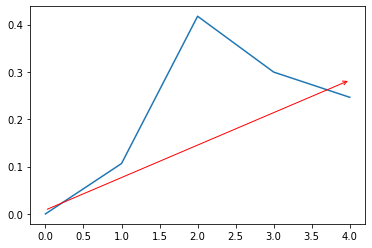

In [25]:
visualize_freq_slope(splits,dictionary,words=["coronavirus","covid","covid-19","koronavirus","koronavirusa"])

[0.2756425, 0.121716425, 0.09270769, 0.06362584, 0.057077624]
Slope: -0.04952203631401062


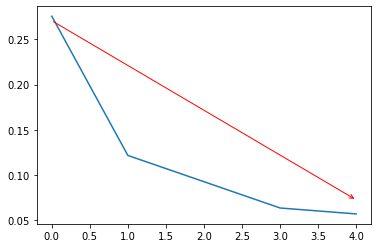

In [26]:
visualize_freq_slope(splits,dictionary,words=["altsasuko","altsasu"])


[0.00023153507, 0.023331702, 0.16685635, 0.19153859, 0.22264211]
Slope: 0.06130280329089147


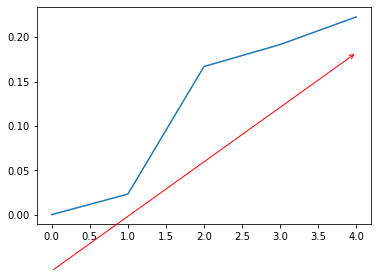

In [27]:
visualize_freq_slope(splits,dictionary,words=["pandemia"])

[0.00034730262, 0.00048947625, 8.754268e-05, 0.00033052388, 0.0003936388]
Slope: -6.62800157442689e-06


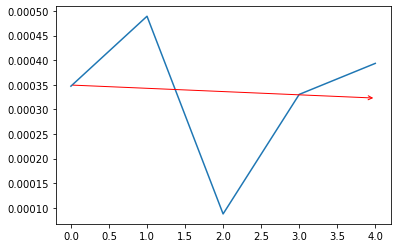

In [28]:
visualize_freq_slope(splits,dictionary,words=["eguzkia"])

[0.00046307014, 0.0024473814, 0.0014006828, 0.0014047265, 0.0037789324]
Slope: 0.000558906962396577


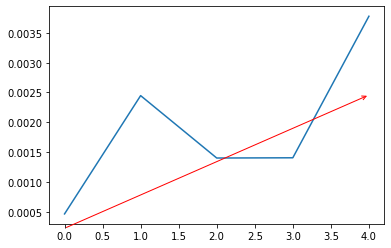

In [29]:
visualize_freq_slope(splits,dictionary,words=["elurra","negua"])

[0.0, 0.005057921, 0.44804344, 0.10237977, 0.091560386]
Slope: 0.02804426201619208


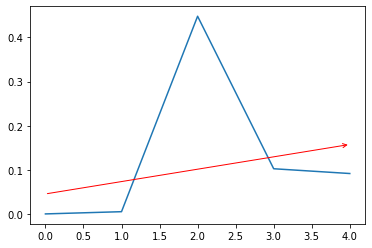

In [30]:
visualize_freq_slope(splits,dictionary,words=["konfinamendu"])

[0.11102107, 0.08631098, 0.07388602, 0.09279458, 0.10053535]
Slope: -0.0014487847685813904


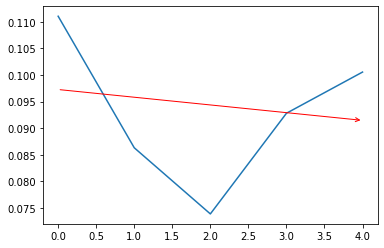

In [31]:
visualize_freq_slope(splits,dictionary,words=["pozik"])

[0.0067145173, 0.006036874, 0.0063906154, 0.0059494297, 0.019052118]
Slope: 0.00245877574197948


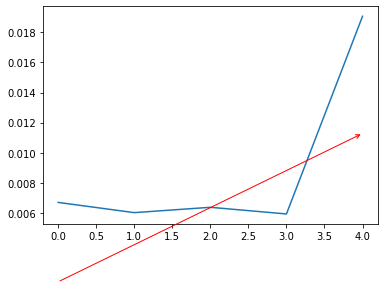

In [32]:
visualize_freq_slope(splits,dictionary,words=["depresio"])

[0.000115767536, 0.0003263175, 0.039656833, 0.12278962, 0.065501496]
Slope: 0.025323476117046086


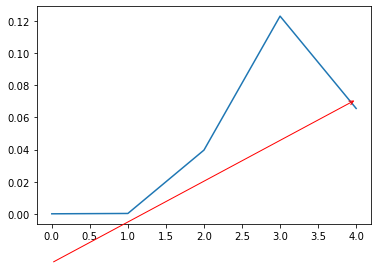

In [33]:
visualize_freq_slope(splits,dictionary,words=["pcr"])

[0.012618662, 0.029368576, 0.06661998, 0.15625517, 0.2938907]
Slope: 0.06894307006150484


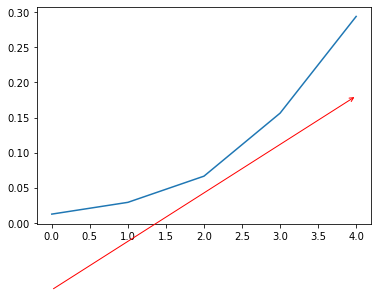

In [34]:
visualize_freq_slope(splits,dictionary,words=["2021"])

[0.039592497, 0.013868494, 0.052875776, 0.090728804, 0.030388916]
Slope: 0.00584531482309103


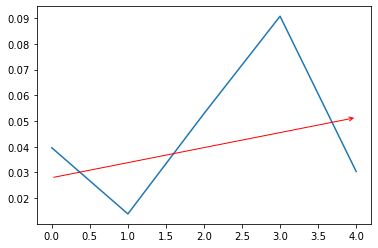

In [35]:
visualize_freq_slope(splits,dictionary,words=["hondartza"])

[0.0015049779, 0.00261054, 0.009629695, 0.005618906, 0.005196032]
Slope: 0.0010390474461019039


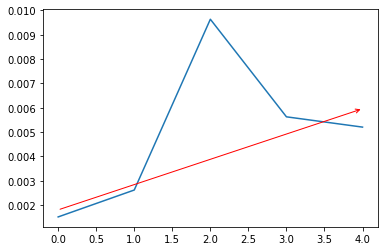

In [36]:
visualize_freq_slope(splits,dictionary,words=["bill","gates"])

[0.06737671, 0.04813183, 0.04132014, 0.039662868, 0.032750748]
Slope: -0.0077720887959003455


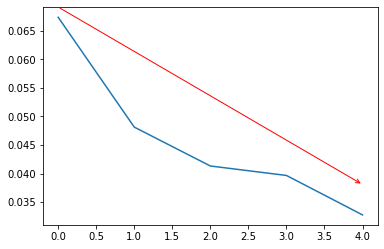

In [37]:
visualize_freq_slope(splits,dictionary,words=["miguel","bose"])

[0.014586709, 0.007015826, 0.037993524, 0.009254669, 0.03267202]
Slope: 0.003840946685522795


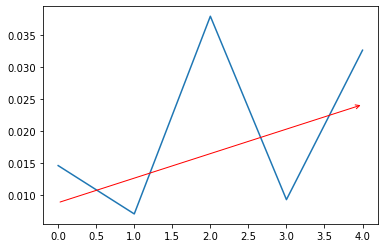

In [38]:
visualize_freq_slope(splits,dictionary,words=["amazon","justeat","uber"])

[0.0021995832, 0.0050579216, 0.049899325, 0.012146752, 0.017792473]
Slope: 0.0038274609483778485


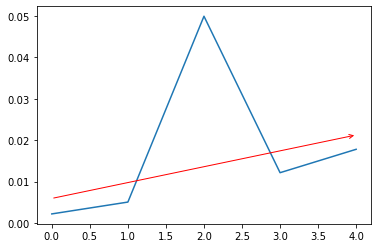

In [39]:
visualize_freq_slope(splits,dictionary,words=["zoom","skype","meet","jitsi"])

[0.0, 0.0, 0.0015757682, 0.00041315486, 0.0014170996]
Slope: 0.0003247354092309252


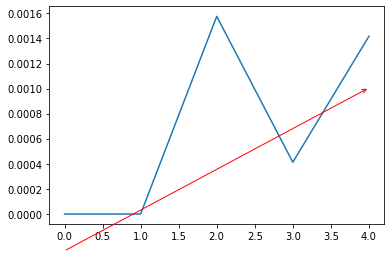

In [40]:
visualize_freq_slope(splits,dictionary,words=["telelana"])

# Analize Emojis

[0.00074717903, 0.0009863502, 7.120798e-05, 0.0005314242, 0.0005059502]
Slope: -9.373837383463979e-05


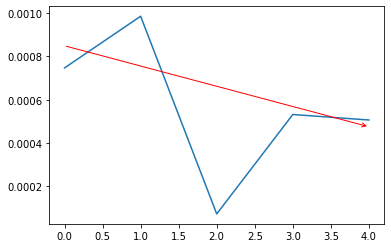

In [41]:
visualize_freq_slope(emoji_splits,emoji_dictionary,words=["🎟"])

[0.00035055316, 0.00032973092, 0.0011052717, 0.00055834965, 0.00082970585]
Slope: 0.00011869241134263576


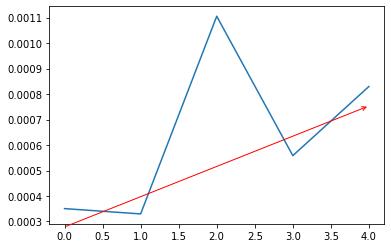

In [42]:
visualize_freq_slope(emoji_splits,emoji_dictionary,words=["💻"])

[0.0007652075, 0.00049175386, 0.0003219839, 0.00036703696, 0.00017826223]
Slope: -0.00012986074725631624


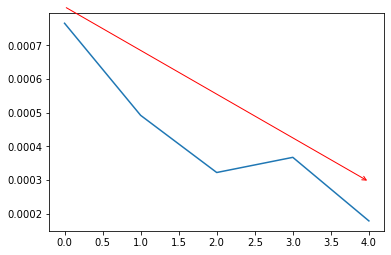

In [43]:
visualize_freq_slope(emoji_splits,emoji_dictionary,words=["🚌"])

[4.8075864e-05, 0.0004661713, 0.0015882476, 0.0012059786, 0.00084805634]
Slope: 0.00023397682161885314


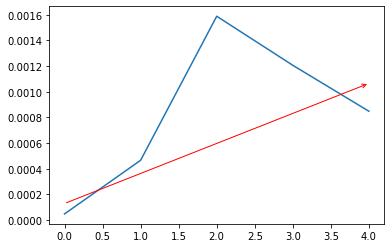

In [44]:
visualize_freq_slope(emoji_splits,emoji_dictionary,words=["😷"])

[0.00015023707, 0.00051449396, 0.0003715199, 0.0017444884, 0.0023619747]
Slope: 0.0005653469619574025


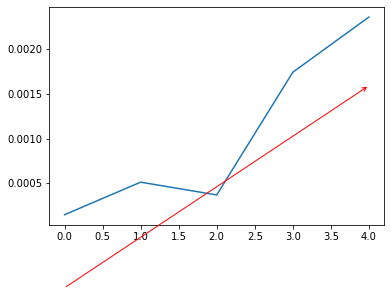

In [45]:
visualize_freq_slope(emoji_splits,emoji_dictionary,words=["🦁"])


[0.0, 0.0, 0.0, 0.0, 0.0]
Slope: 0.0


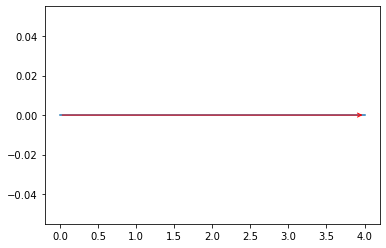

In [46]:
visualize_freq_slope(emoji_splits,emoji_dictionary,words=["🏄🏻"])


# Generate work2vec models

<ipython-input-50-3222a66ba80b>:35: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  ms = model.most_similar(positive=words, topn=k*100)
<ipython-input-50-3222a66ba80b>:40: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  vectors = np.asarray([model[word] for word in vocab])


Most similar: ['birusaren', 'kasuak', 'datuen', 'kasuen', 'agerraldiak', 'hedapena', 'balizko', 'pandemia', 'datuak', 'arau', 'arabera,', 'gaitzaren', 'covid']


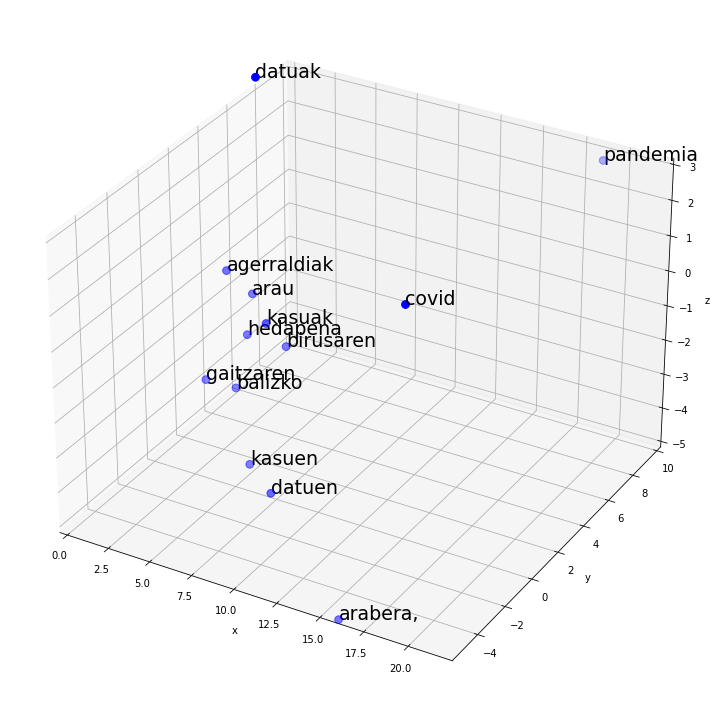

In [52]:
visualize_knn(models[3],["covid"],12,ban=["covid","kovid","19","corona","korona","http","dela","eae","pandemiaren","/"],xlim=(0,22),ylim=(-5.5,10),zlim=(-5,3))

<ipython-input-94-00782538d737>:71: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  ms = model.most_similar(positive=words, topn=k*100)
<ipython-input-94-00782538d737>:76: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  vectors = np.asarray([model[word] for word in vocab])


Most similar: ['birusaren', 'kasuak', 'datuen', 'kasuen', 'agerraldiak', 'hedapena', 'balizko', 'pandemia', 'datuak', 'arau', 'arabera,', 'gaitzaren', 'isolatu', 'sintomak', 'iragarritako', 'aldaketak', 'osakidetzak', 'larrialdi', 'tasa', 'egoeraren', 'covid']


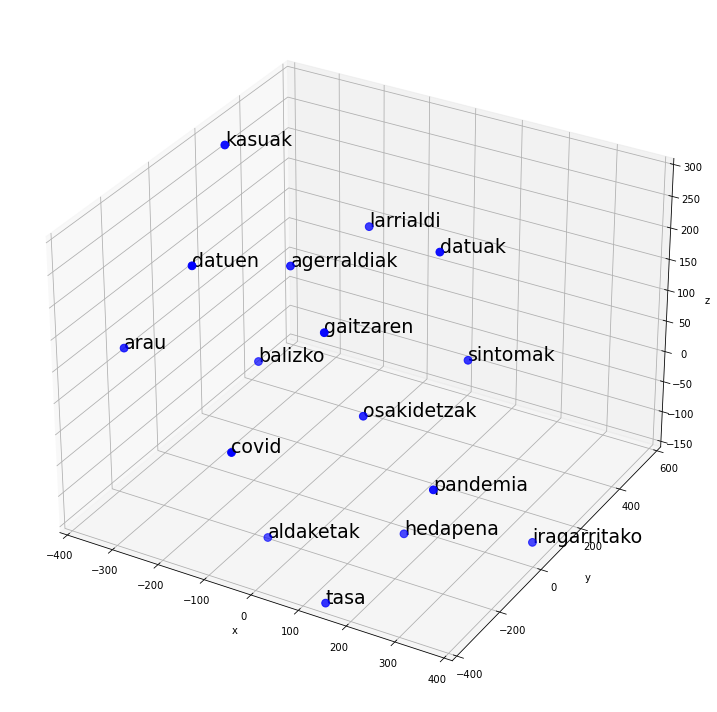

In [102]:
visualize_knn_tsne(models[3],["covid"],20,ban=["covid","kovid","19","corona","korona","http","dela","eae","pandemiaren","/"],xlim=(-400,400),ylim=(-400,600),zlim=(-150,300))

<ipython-input-64-cde9056e1764>:66: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  ms = model.most_similar(positive=words, topn=k*100)
<ipython-input-64-cde9056e1764>:71: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  vectors = np.asarray([model[word] for word in vocab])


Most similar: ['birusaren', 'kasuak', 'datuen', 'kasuen', 'agerraldiak', 'hedapena', 'balizko', 'pandemia', 'datuak', 'arau', 'arabera,', 'gaitzaren', 'covid']


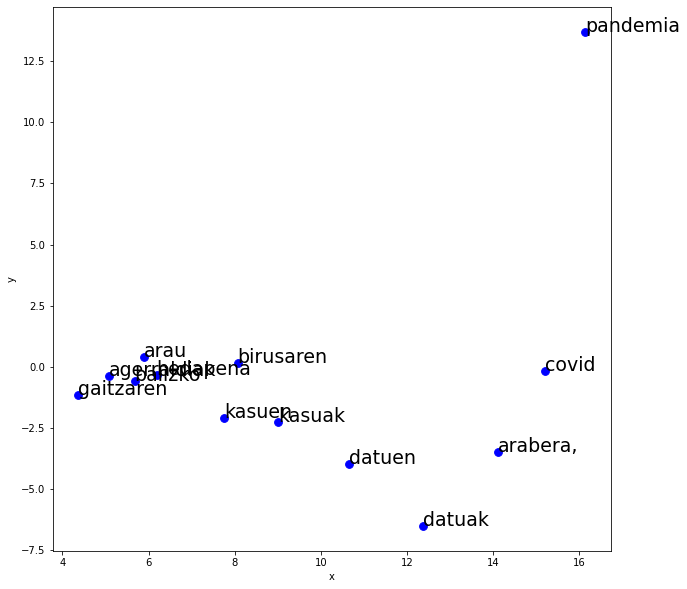

In [66]:
visualize_knn_2D(models[3],["covid"],12,ban=["covid","kovid","19","corona","korona","http","dela","eae","pandemiaren","/"])

<ipython-input-94-00782538d737>:71: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  ms = model.most_similar(positive=words, topn=k*100)
<ipython-input-94-00782538d737>:76: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  vectors = np.asarray([model[word] for word in vocab])


Most similar: ['#athleticclub', '#athleticclubfem', '#athleticlezama', '#sevillaathletic', '#realvalladolidathletic', '#ehkopa', '#añorga', '#eskerrikaskobeñat', '#athlive', '#eibarosasuna', '#ehtxapela', '🦁#eskerrikaskobeñat', '#edflogroñoathletic', '#eibarathletic', '@aurreravitoria', '#osasunaathletic', '#ehkirola', '🏟️', '🆚', '⚽', '🦁']


/home/iker/miniconda3/envs/meta/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 129409 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/iker/miniconda3/envs/meta/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 127967 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/iker/miniconda3/envs/meta/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 127386 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/iker/miniconda3/envs/meta/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 9917 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/iker/miniconda3/envs/meta/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 129409 missing from current font.
  font.set_text(s, 0, flags=flags)
/home/iker/miniconda3/envs/meta/lib/pyt

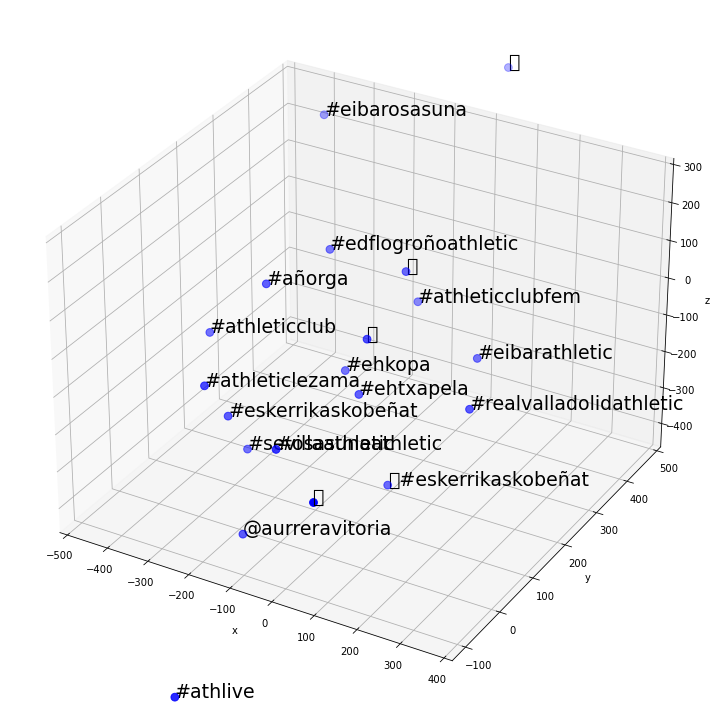

In [114]:
visualize_knn_tsne(models[3],["🦁"],20,ban=["http","\""],xlim=(-500,400),ylim=(-125,500),zlim=(-450,300))

Most similar: ['#athleticclub', '#athleticclubfem', 'https://t.co/jth0urteed', '#athleticlezama', 'https://t.co/78pppjt5k9', '#sevillaathletic', '#realvalladolidathletic', 'https://t.co/qvwpns9nf7', 'https://t.co/q4xwwprovd', '#ehkopa', '#añorga', '🦁"', '🦁']


<ipython-input-64-cde9056e1764>:66: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  ms = model.most_similar(positive=words, topn=k*100)
<ipython-input-64-cde9056e1764>:71: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  vectors = np.asarray([model[word] for word in vocab])
/home/iker/miniconda3/envs/meta/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 129409 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/iker/miniconda3/envs/meta/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 129409 missing from current font.
  font.set_text(s, 0, flags=flags)


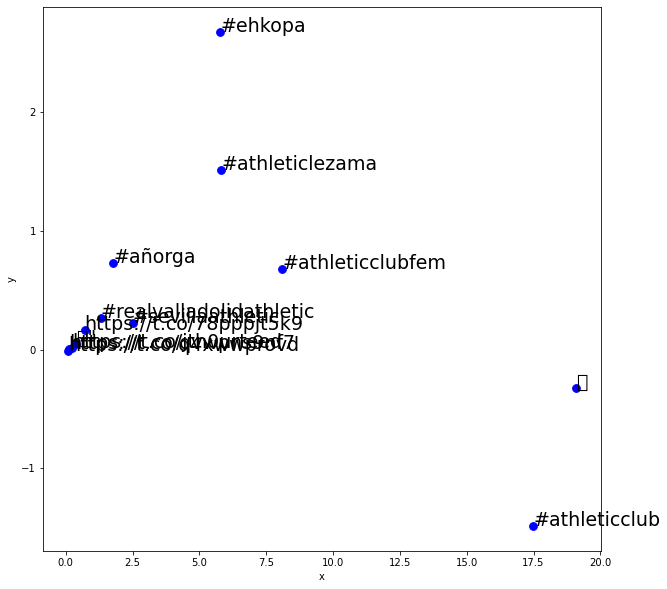

In [65]:
visualize_knn_2D(models[3],["🦁"],12,ban=[])